In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns

Read in external CH4 emission data

In [3]:
from core_fct.mod_process import OSCAR
from core_fct.fct_loadP import load_all_param
from core_fct.fct_genMC import generate_config
from run_scripts.get_SSP_drivers import For_hist
from run_scripts.get_SSP_drivers import For_scen

loading primary parameters


In [4]:
import csv

In [5]:
import statsmodels.api as sm

In [6]:
import seaborn as sns

In [7]:
var_keep = ['D_Eluc', 'D_Focean', 'D_Fland', 'D_Epf'] + ['tau_CH4', 'tau_N2O'] + ['RF_CH4','RF_O3t']+['D_O3t']+['f_kOH_O3P']+['f_kOH']+['D_Ewet','D_Epf_CH4','D_Ebb']

In [8]:
# Par0 = load_all_param(mod_region='RCP_5reg')
# Par = generate_config(Par0, nMC=200)
# Par = xr.merge([Par, For_hist.drop([VAR for VAR in For_hist if 'year' in For_hist[VAR].dims])])
# For_hist = For_hist.drop([VAR for VAR in For_hist if 'year' not in For_hist[VAR].dims])
# Out_hist = OSCAR(Ini=None, Par=Par, For=For_hist)

In [9]:
ch4 = pd.read_excel('ex_data/concentration/ch4.xlsx')

emi = pd.read_excel('ex_data/emi/emi.xlsx')[:-2]
oh = pd.read_excel('ex_data/oh/oh.xlsx')
wetland = pd.read_excel('ex_data/wetland/wetland.xlsx')
biomass = pd.read_excel('ex_data/biomass/biomass.xlsx')

In [10]:
emi_list = ['ceds','edgar','gains']
oh_list = ['ceds','edgar','Turner','Skeie','Nicely','He']
wetland_list = ['Skeie','Chandra','Zhang','Wetcharts']
biomass_list =['biomass']

In [24]:
df = pd.read_csv('ex_data/concentration/ch4_incr.csv')[:-1]
df.head()
obs = df['inc']
obs_unc = df['unc']

In [11]:
# ##  用于测试
# For_hist_tmp = For_hist.sel(year=slice(1981, 2014))
# For_scen_tmp = For_scen.sel(year=slice(2015, 2018)).sel(scen='SSP2-4.5').drop('scen')
# For_contact = xr.concat([For_hist_tmp,For_scen_tmp], dim='year')
# For_contact = For_contact.drop_vars('D_CH4')

# Ini = Out_hist.sel(year=1981, drop=True)

# Out_ref = OSCAR(Ini=Ini, Par=Par, For=For_contact, var_keep=var_keep, nt=4)

In [26]:
with xr.open_dataset('./init/Ini.nc') as TMP: 
    Ini = TMP.load()
with xr.open_dataset('./init/Par.nc') as TMP: 
    Par = TMP.load()
with xr.open_dataset('./init/For_contact.nc') as TMP: 
    For = TMP.load()
with xr.open_dataset('./init/Out_ref.nc') as TMP: 
    Out_ref = TMP.load()

In [22]:
# Ini = Out_hist.sel(year=1981, drop=True)
ref = []
##### 替换驱动数据并模拟 ####
output = []
n = 0
for var_emi in emi_list:
    For_contact = For.copy(deep=True)
    For_contact = xr.merge([For_contact,Out_ref.f_kOH.mean('config').copy(deep=True),Out_ref.D_Ewet.mean('config').copy(deep=True),Out_ref.D_Ebb.mean('config').copy(deep=True)])
    ### emission ###
    emi_temp = emi[var_emi].values*(1/16*12/1000)
    for i in range(len(emi_temp)):
        For_contact.E_CH4[i,:] *= 0
        For_contact.E_CH4[i,0] += emi_temp[i]    
    
    ### biomass ###     
    for var_biomass in biomass_list:
        biomass_temp = biomass[var_biomass].values
        for year in np.arange(1981,2018+1):
            For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
            For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=year).isel(reg_land=0).isel(bio_land=0).values += biomass_temp[year-1981]          
    


        #### oh ###
        for var_oh in oh_list:
            # print('-'+var_oh)
            oh_temp = oh[var_oh].values
            For_contact.f_kOH.values = oh_temp
            
            ### wetland ###     
            for var_wetland in wetland_list:
                # print('--'+var_wetland)
                wetland_temp = wetland[var_wetland].values
                for year in np.arange(1981,2018+1):
                    For_contact.D_Ewet.sel(year=year).values *= 0
                    For_contact.D_Ewet.sel(year=year).isel(reg_land=0).values += wetland_temp[year-1981] 
                # ### run ###
                n += 1
                text = var_emi+' '+var_oh+' '+var_wetland+' '+var_biomass
                print(text)
                # print(n)
                Out_run = OSCAR(Ini=Ini, Par=Par, For=For_contact, var_keep=var_keep, nt=4)
                Out_run.to_netcdf('results/ref/' + str(n)+'_ref.nc',encoding={var:{'zlib':True, 'dtype':np.float32} for var in Out_ref})
                ref.append(Out_run.D_CH4.mean('config'))
ref = np.array(ref)

ceds ceds Skeie biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
ceds ceds Chandra biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
ceds ceds Zhang biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
ceds ceds Wetcharts biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
ceds edgar Skeie biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.4 minutes
ceds edgar Chandra biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
ceds edgar Zhang biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
ceds edgar Wetcharts biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.4 minutes
ceds Turner Skeie biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
ceds Turner Chandra biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
ceds Turner Zhang biomass
OSCAR_v3 run

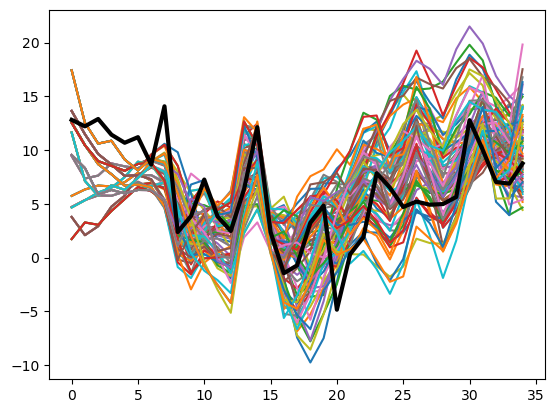

In [25]:
plt.plot(np.diff(ref,1)[:,2:].T)

plt.plot(obs,color='k',linewidth=3)

归因算法。只有某一强迫驱动，其它强迫恒定为初始值。

In [158]:
# 循环

In [39]:
### 循环
##### 替换驱动数据并模拟 ####
output = []
output_ci = []
n = 0
for var_emi in emi_list:

    # 选取研究年份 1981-2018
    For_hist_tmp = For_hist.sel(year=slice(1981, 2014))
    For_scen_tmp = For_scen.sel(year=slice(2015, 2018)).sel(scen='SSP2-4.5').drop('scen')
    For_contact = xr.concat([For_hist_tmp,For_scen_tmp], dim='year')
    For_contact = For_contact.drop_vars('D_CH4')
    
    For_contact = xr.merge([For_contact,Out_ref.f_kOH.mean('config').copy(deep=True),Out_ref.D_Ewet.mean('config').copy(deep=True),Out_ref.D_Ebb.mean('config').copy(deep=True)])

    ### emission ###
    emi_temp = emi[var_emi].values*(1/16*12/1000)
    for i in range(len(emi_temp)):
        For_contact.E_CH4[i,:] *= 0
        For_contact.E_CH4[i,0] += emi_temp[i]    
    
    ### biomass ###     
    for var_biomass in biomass_list:
        biomass_temp = biomass[var_biomass].values
        for year in np.arange(1981,2018+1):
            For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
            For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=year).isel(reg_land=0).isel(bio_land=0).values += biomass_temp[year-1981]          
    


        #### oh ###
        for var_oh in oh_list:
            # print('-'+var_oh)
            oh_temp = oh[var_oh].values
            For_contact.f_kOH.values = oh_temp
            
            ### wetland ###     
            for var_wetland in wetland_list:
                # print('--'+var_wetland)
                wetland_temp = wetland[var_wetland].values
                for year in np.arange(1981,2018+1):
                    For_contact.D_Ewet.sel(year=year).values *= 0
                    For_contact.D_Ewet.sel(year=year).isel(reg_land=0).values += wetland_temp[year-1981]
                    

                        
                # ### run ###
                n += 1
                print(var_emi+' '+var_oh+' '+var_wetland+' '+var_biomass)
                #########################
                #########################
                #########################
                Attribution = []

                ### emi
                For_contact_tmp = For_contact.copy(deep=True)
                for year in For_contact_tmp.year[1:]:

                    # For_contact_tmp.E_CH4.sel(year=year).values *= 0
                    # For_contact_tmp.E_CH4.sel(year=year).values += For_contact.E_CH4.sel(year=1981).values

                    For_contact_tmp.f_kOH.sel(year=year).values *= 0
                    For_contact_tmp.f_kOH.sel(year=year).values += For_contact.f_kOH.sel(year=1981).values

                    For_contact_tmp.D_Ewet.sel(year=year).values *= 0
                    For_contact_tmp.D_Ewet.sel(year=year).values += For_contact.D_Ewet.sel(year=1981).values

                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values += For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=1981).values
                print('emi')
                Out_emi = OSCAR(Ini=Ini, Par=Par, For=For_contact_tmp, var_keep=var_keep, nt=4)
                Out_emi.to_netcdf('results/attr/' + str(n)+'_emi.nc',encoding={var:{'zlib':True, 'dtype':np.float32} for var in Out_emi})
                Attribution.append(Out_emi)
                ### oh
                For_contact_tmp = For_contact.copy(deep=True)
                for year in For_contact_tmp.year[1:]:

                    For_contact_tmp.E_CH4.sel(year=year).values *= 0
                    For_contact_tmp.E_CH4.sel(year=year).values += For_contact.E_CH4.sel(year=1981).values

                    # For_contact_tmp.f_kOH.sel(year=year).values *= 0
                    # For_contact_tmp.f_kOH.sel(year=year).values += For_contact.f_kOH.sel(year=1981).values

                    For_contact_tmp.D_Ewet.sel(year=year).values *= 0
                    For_contact_tmp.D_Ewet.sel(year=year).values += For_contact.D_Ewet.sel(year=1981).values

                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values += For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=1981).values
                print('oh')
                Out_oh = OSCAR(Ini=Ini, Par=Par, For=For_contact_tmp, var_keep=var_keep, nt=4)
                Out_oh.to_netcdf('results/attr/' + str(n)+'_oh.nc',encoding={var:{'zlib':True, 'dtype':np.float32} for var in Out_oh})
                Attribution.append(Out_oh)
                ### wetland
                For_contact_tmp = For_contact.copy(deep=True)
                for year in For_contact_tmp.year[1:]:

                    For_contact_tmp.E_CH4.sel(year=year).values *= 0
                    For_contact_tmp.E_CH4.sel(year=year).values += For_contact.E_CH4.sel(year=1981).values

                    For_contact_tmp.f_kOH.sel(year=year).values *= 0
                    For_contact_tmp.f_kOH.sel(year=year).values += For_contact.f_kOH.sel(year=1981).values

                    # For_contact_tmp.D_Ewet.sel(year=year).values *= 0
                    # For_contact_tmp.D_Ewet.sel(year=year).values += For_contact.D_Ewet.sel(year=1981).values

                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values += For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=1981).values
                print('wetland')
                Out_wetland = OSCAR(Ini=Ini, Par=Par, For=For_contact_tmp, var_keep=var_keep, nt=4)
                Out_wetland.to_netcdf('results/attr/' + str(n)+'_wetland.nc',encoding={var:{'zlib':True, 'dtype':np.float32} for var in Out_wetland})
                Attribution.append(Out_wetland)
                ### biomass
                For_contact_tmp = For_contact.copy(deep=True)
                for year in For_contact_tmp.year[1:]:

                    For_contact_tmp.E_CH4.sel(year=year).values *= 0
                    For_contact_tmp.E_CH4.sel(year=year).values += For_contact.E_CH4.sel(year=1981).values

                    For_contact_tmp.f_kOH.sel(year=year).values *= 0
                    For_contact_tmp.f_kOH.sel(year=year).values += For_contact.f_kOH.sel(year=1981).values

                    For_contact_tmp.D_Ewet.sel(year=year).values *= 0
                    For_contact_tmp.D_Ewet.sel(year=year).values += For_contact.D_Ewet.sel(year=1981).values

                #     For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
                #     For_contact_tmp.D_Ebb.sel(spc_bb='CH4').values += For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=1981).values
                print('biomass')
                Out_biomass = OSCAR(Ini=Ini, Par=Par, For=For_contact_tmp, var_keep=var_keep, nt=4)
                Out_biomass.to_netcdf('results/attr/' + str(n)+'_biomass.nc',encoding={var:{'zlib':True, 'dtype':np.float32} for var in Out_biomass})
                Attribution.append(Out_biomass)
                #########################
                #########################
                #########################
                y = obs
                x = np.array([Attribution[0].D_CH4.mean('config').diff('year')[2:],Attribution[1].D_CH4.mean('config').diff('year')[2:],
                     Attribution[2].D_CH4.mean('config').diff('year')[2:],Attribution[3].D_CH4.mean('config').diff('year')[2:]]).T
                x = np.array(x)
                y = np.array(y)
                x = sm.add_constant(x)
                results = sm.OLS(y, x).fit()
                output.append(results.params[1:])
                output_ci.append(((np.diff(results.conf_int())/2)[1:]).flatten())

ceds ceds Skeie biomass
emi
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
oh
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
wetland
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
ceds ceds Chandra biomass
emi
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
oh
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
wetland
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
ceds ceds Zhang biomass
emi
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
oh
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
wetland
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
ceds ceds Wetchar

In [40]:
### 循环
##### 替换驱动数据并模拟 ####

################################
###  平均值驱动
################################

output = []
output_ci = []
n = 0
for var_emi in emi_list:

    # 选取研究年份 1981-2018
    For_hist_tmp = For_hist.sel(year=slice(1981, 2014))
    For_scen_tmp = For_scen.sel(year=slice(2015, 2018)).sel(scen='SSP2-4.5').drop('scen')
    For_contact = xr.concat([For_hist_tmp,For_scen_tmp], dim='year')
    For_contact = For_contact.drop_vars('D_CH4')
    
    For_contact = xr.merge([For_contact,Out_ref.f_kOH.mean('config').copy(deep=True),Out_ref.D_Ewet.mean('config').copy(deep=True),Out_ref.D_Ebb.mean('config').copy(deep=True)])

    ### emission ###
    emi_temp = emi[var_emi].values*(1/16*12/1000)
    for i in range(len(emi_temp)):
        For_contact.E_CH4[i,:] *= 0
        For_contact.E_CH4[i,0] += emi_temp[i]    
    
    ### biomass ###     
    for var_biomass in biomass_list:
        biomass_temp = biomass[var_biomass].values
        for year in np.arange(1981,2018+1):
            For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
            For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=year).isel(reg_land=0).isel(bio_land=0).values += biomass_temp[year-1981]          
    


        #### oh ###
        for var_oh in oh_list:
            # print('-'+var_oh)
            oh_temp = oh[var_oh].values
            For_contact.f_kOH.values = oh_temp
            
            ### wetland ###     
            for var_wetland in wetland_list:
                # print('--'+var_wetland)
                wetland_temp = wetland[var_wetland].values
                for year in np.arange(1981,2018+1):
                    For_contact.D_Ewet.sel(year=year).values *= 0
                    For_contact.D_Ewet.sel(year=year).isel(reg_land=0).values += wetland_temp[year-1981]
                    

                        
                # ### run ###
                n += 1
                print(var_emi+' '+var_oh+' '+var_wetland+' '+var_biomass)
                #########################
                #########################
                #########################
                Attribution = []

                ### emi
                For_contact_tmp = For_contact.copy(deep=True)
                for year in For_contact_tmp.year[1:]:

                    # For_contact_tmp.E_CH4.sel(year=year).values *= 0
                    # For_contact_tmp.E_CH4.sel(year=year).values += For_contact.E_CH4.sel(year=1981).values

                    For_contact_tmp.f_kOH.sel(year=year).values *= 0
                    For_contact_tmp.f_kOH.sel(year=year).values += For_contact.f_kOH.mean('year').values

                    For_contact_tmp.D_Ewet.sel(year=year).values *= 0
                    For_contact_tmp.D_Ewet.sel(year=year).values += For_contact.D_Ewet.mean('year').values

                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values += For_contact.D_Ebb.sel(spc_bb='CH4').mean('year').values
                print('emi')
                Out_emi = OSCAR(Ini=Ini, Par=Par, For=For_contact_tmp, var_keep=var_keep, nt=4)
                Out_emi.to_netcdf('results/attr2/' + str(n)+'_emi.nc',encoding={var:{'zlib':True, 'dtype':np.float32} for var in Out_emi})
                Attribution.append(Out_emi)
                ### oh
                For_contact_tmp = For_contact.copy(deep=True)
                for year in For_contact_tmp.year[1:]:

                    For_contact_tmp.E_CH4.sel(year=year).values *= 0
                    For_contact_tmp.E_CH4.sel(year=year).values += For_contact.E_CH4.mean('year').values

                    # For_contact_tmp.f_kOH.sel(year=year).values *= 0
                    # For_contact_tmp.f_kOH.sel(year=year).values += For_contact.f_kOH.sel(year=1981).values

                    For_contact_tmp.D_Ewet.sel(year=year).values *= 0
                    For_contact_tmp.D_Ewet.sel(year=year).values += For_contact.D_Ewet.mean('year').values

                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values += For_contact.D_Ebb.sel(spc_bb='CH4').mean('year').values
                print('oh')
                Out_oh = OSCAR(Ini=Ini, Par=Par, For=For_contact_tmp, var_keep=var_keep, nt=4)
                Out_oh.to_netcdf('results/attr2/' + str(n)+'_oh.nc',encoding={var:{'zlib':True, 'dtype':np.float32} for var in Out_oh})
                Attribution.append(Out_oh)
                ### wetland
                For_contact_tmp = For_contact.copy(deep=True)
                for year in For_contact_tmp.year[1:]:

                    For_contact_tmp.E_CH4.sel(year=year).values *= 0
                    For_contact_tmp.E_CH4.sel(year=year).values += For_contact.E_CH4.mean('year').values

                    For_contact_tmp.f_kOH.sel(year=year).values *= 0
                    For_contact_tmp.f_kOH.sel(year=year).values += For_contact.f_kOH.mean('year').values

                    # For_contact_tmp.D_Ewet.sel(year=year).values *= 0
                    # For_contact_tmp.D_Ewet.sel(year=year).values += For_contact.D_Ewet.sel(year=1981).values

                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
                    For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values += For_contact.D_Ebb.sel(spc_bb='CH4').mean('year').values
                print('wetland')
                Out_wetland = OSCAR(Ini=Ini, Par=Par, For=For_contact_tmp, var_keep=var_keep, nt=4)
                Out_wetland.to_netcdf('results/attr2/' + str(n)+'_wetland.nc',encoding={var:{'zlib':True, 'dtype':np.float32} for var in Out_wetland})
                Attribution.append(Out_wetland)
                ### biomass
                For_contact_tmp = For_contact.copy(deep=True)
                for year in For_contact_tmp.year[1:]:

                    For_contact_tmp.E_CH4.sel(year=year).values *= 0
                    For_contact_tmp.E_CH4.sel(year=year).values += For_contact.E_CH4.mean('year').values

                    For_contact_tmp.f_kOH.sel(year=year).values *= 0
                    For_contact_tmp.f_kOH.sel(year=year).values += For_contact.f_kOH.mean('year').values

                    For_contact_tmp.D_Ewet.sel(year=year).values *= 0
                    For_contact_tmp.D_Ewet.sel(year=year).values += For_contact.D_Ewet.mean('year').values

                #     For_contact_tmp.D_Ebb.sel(spc_bb='CH4').sel(year=year).values *= 0
                #     For_contact_tmp.D_Ebb.sel(spc_bb='CH4').values += For_contact.D_Ebb.sel(spc_bb='CH4').sel(year=1981).values
                print('biomass')
                Out_biomass = OSCAR(Ini=Ini, Par=Par, For=For_contact_tmp, var_keep=var_keep, nt=4)
                Out_biomass.to_netcdf('results/attr2/' + str(n)+'_biomass.nc',encoding={var:{'zlib':True, 'dtype':np.float32} for var in Out_biomass})
                Attribution.append(Out_biomass)
                #########################
                #########################
                #########################

ceds ceds Skeie biomass
emi
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
oh
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
wetland
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
ceds ceds Chandra biomass
emi
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
oh
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
wetland
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
ceds ceds Zhang biomass
emi
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.3 minutes
oh
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
wetland
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
biomass
OSCAR_v3 running
year = 2018 (nt = 4)
total running time: 1.2 minutes
ceds ceds Wetchar

In [31]:
output = np.array(output)
path = 'output/'
filename = 'attr.csv'

with open(path+filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(output)
    
output_ci = np.array(output_ci)
path = 'output/'
filename = 'attr_ci.csv'

with open(path+filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(output_ci)